# Modell Predictive Control

In [47]:
import osqp
import numpy as np
import scipy as sp
from scipy import sparse
import scipy.signal as sig
import matplotlib.pyplot as plt
from control import dare, dlqr

## 1. Model

In [48]:
# Model parameters
g = 9.81
m = 1
l = 0.3
J = 0.2*m*l**2

h = 0.05   # Time step 20 Hz

In [49]:
# Modell
def quad_dynamics(t,x,u):   
    '''
    x:         [x, y, theta, xd, yd, thetad]
    '''
    xd = np.zeros(len(x))

    theta = x[2]

    xd[3] = (u[0] + u[1])*np.sin(theta)/m     #xdd
    xd[4] = (u[0] + u[1])*np.cos(theta)/m -g  # ydd    
    xd[5] = (u[1] - u[0])*l/(J*2)            # thetadd
    
    xd[0],xd[1], xd[2] = x[3],x[4],x[5] 
    return xd

In [50]:
def runge_kutta_k4(f,x,u,h=1):
    
    #RK4 integration with zero-order hold on u
    #h = 0.05      # time step (20Hz) 
    t = 0
    f1 = f(t,x, u)
    f2 = f(t,x + 1/2*h*f1, u)
    f3 = f(t,x + 1/2*h*f2, u)
    f4 = f(t,x + h*f3, u)

    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)

In [51]:
# Model
A = np.array([[0,0,0,  1,0,0],
              [0,0,0,  0,1,0],
              [0,0,0,  0,0,1],
              [0,0,-g, 0,0,0],
              [0,0,0,  0,0,0],
              [0,0,0,  0,0,0]])
B = np.array([[0,0],
              [0,0],
              [0,0],
              [0,0],
              [1/m, 1/m],
              [-l/(2*J), l/(2*J)]])

Ta = 0.05
C = np.ones((2,6))
D = np.zeros((2,2))
# Constraints
Ad_,Bd_,Cd,Dd,Ta = sig.cont2discrete((A,B,C,D),Ta, method='zoh')


Ad_ = np.absolute(Ad_)
#Bd_[0,:] *= -1
#Bd_[3,:] *= -1


Ad = sparse.csr_matrix(Ad_)
Bd = sparse.csr_matrix(Bd_)

x_hover = np.zeros(6)
u_hover = np.array([0.5*m*g, 0.5*m*g])




In [52]:
# LQR
nx = 6
nu = 2
Q = 1*np.eye(nx)
QN = 1*np.eye(nx)
R = .01*np.eye(nu)

X, L, G = dare(Ad_, Bd_, Q, R) 
K, S, E = dlqr(Ad_, Bd_, Q, R) 

lqr_controller = lambda t,prob,x,xref: u_hover-K@np.subtract(x,xref) 

# Gain Matrix
P = sp.linalg.solve_discrete_are(Ad_,Bd_,Q,R)
H = sp.linalg.inv(R+Bd_.transpose()@P@Bd_)
K = H@Bd_.transpose()@P@Ad_
X = P.copy()


## 2. MPC (Quadratic Problem)
**https://github.com/qpsolvers/qpsolvers**      
https://osqp.org/docs/examples/mpc.html       
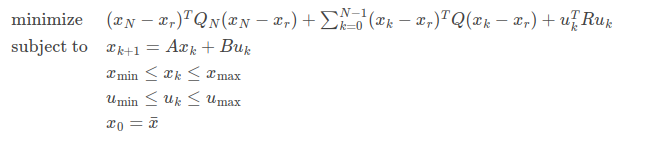

### 2.1 Setup MPC Problem
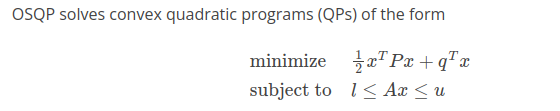    
**Volldiskretisierung des Problems**   
$
z = \begin{bmatrix} \tilde{x}_{0} & \cdots & \tilde{x}_{N} & u_{0} & \cdots & u_{N-1}
\end{bmatrix}
mit \quad  \tilde{x}=x-x_{ref}$   
$
P =
\begin{bmatrix}
     Q_{0} & \cdots & 0 \cdots & &\cdots & 0    \\
     \vdots & \ddots & \vdots  & &\ddots & \vdots  \\
     0 & \cdots & Q_{N} &      \\
     \vdots & & & R_{0} & \cdots & 0         \\
     \vdots & & &\vdots & \ddots & \vdots   \\
     0 & \cdots & & 0 & \cdots & R_{N-1}
\end{bmatrix}
A_{eq} =
\begin{bmatrix}
     -I &  0 & \cdots & 0 \\
      A & -I & \cdots & 0 \\
      \vdots & \ddots & \ddots & 0 \\
      \vdots & \cdots & A_{N} & -I      
\end{bmatrix}  
B_{eq} =
\begin{bmatrix}
      0 &  0 & \cdots & 0 \\
      B_{0} & 0 & \cdots & 0 \\
      \vdots & \ddots & \ddots & 0 \\
      \vdots & \cdots & 0 & B_{N-1}      
\end{bmatrix}  
 A = 
\begin{bmatrix}
A_{eq}  B_{eq} \\
I
\end{bmatrix}
$

$
l_{eq}=
\begin{bmatrix}
-x_{0} & 0
\end{bmatrix}  \quad 
l_{ineq}=
\begin{bmatrix}
x_{min} & u_{min}
\end{bmatrix}  \quad 
l=
\begin{bmatrix}
l_{eq} & l_{ineq}
\end{bmatrix}
$   
$
u_{eq}=
\begin{bmatrix}
-x_{0} & 0
\end{bmatrix}  \quad 
u_{ineq}=
\begin{bmatrix}
x_{max} & u_{max}
\end{bmatrix}  \quad 
u=
\begin{bmatrix}
u_{eq} & u_{ineq}
\end{bmatrix}
$




In [53]:
[nx, nu] = Bd.shape


# Constraints
u_hover = 0.5*m*g
umin = np.array([0.2*m*g, 0.2*m*g]) 
umax = np.array([0.6*m*g, 0.6*m*g]) 

xmin = np.array([np.inf, 0, np.inf,
                 np.inf, np.inf, np.inf])*(-1)  
xmax = np.array([ np.inf, np.inf, np.inf, 
                  np.inf,np.inf, np.inf])

# Objective function
Q = 1*sparse.eye(nx)
QN = X #10*sparse.eye(nx) 
R = 0.01*sparse.eye(nu)

# Initial and reference states
x0 = np.array([0,1,0, 0,0,0])#np.zeros(nx)
xr = np.zeros(nx)

# Prediction horizon
N = 10


# Cast MPC problem to a QP: x = (x(0),x(1),...,x(N),u(0),...,u(N-1))
# - quadratic objective
P = sparse.block_diag([sparse.kron(sparse.eye(N), Q), QN, sparse.kron(sparse.eye(N), R)], format='csc')
# - linear objective
q = np.hstack([np.kron(np.ones(N), -Q.dot(xr)), -QN.dot(xr),np.zeros(N*nu)])
# - linear dynamics
Ax = sparse.kron(sparse.eye(N+1),-sparse.eye(nx)) + sparse.kron(sparse.eye(N+1, k=-1), Ad)
Bu = sparse.kron(sparse.vstack([sparse.csc_matrix((1, N)), sparse.eye(N)]), Bd)
Aeq = sparse.hstack([Ax, Bu])
leq = np.hstack([-x0, np.zeros(N*nx)])
ueq = leq
# - input and state constraints
Aineq = sparse.eye((N+1)*nx + N*nu)
lineq = np.hstack([np.kron(np.ones(N+1), xmin), np.kron(np.ones(N), (umin-u_hover))])
uineq = np.hstack([np.kron(np.ones(N+1), xmax), np.kron(np.ones(N), (umax-u_hover))])
# - OSQP constraints
Ab = sparse.vstack([Aeq, Aineq], format='csc')
lb = np.hstack([leq, lineq])
ub = np.hstack([ueq, uineq])

# Create an OSQP object
prob = osqp.OSQP()

# Setup workspace
prob.setup(P, q, Ab, lb, ub, verbose=False ) #, eps_abs=1e-8, eps_rel=1e-8, polish=1)


In [54]:
# Alternative 
from qpsolvers import solve_qp
xx = solve_qp(P, q, A=Aeq, b = leq, lb=lineq, ub=uineq, solver="osqp")
print(xx[-N*nu:-(N-1)*nu])

[-2.94298399 -2.94298399]


### 2.2 Simulation

In [55]:
# MPC Controller
def mpc_controller(t,prob,x,xref):
    
    # Update OP problem
    for i in range(0,nx):
        lb[i] = -x[i]
        ub[i] = -x[i]
    
    # Update b_Vector --> Referenzvektor 
    b = np.hstack([np.kron(np.ones(N), -Q@xref), -QN@xref,np.zeros(N*nu)])     
    q_up = b.copy()    
    b_up = np.hstack([-x, np.zeros(N*nx)])
    
    prob.update(q=b, l=lb, u=ub)
    #Solve QP
    res = prob.solve()
    # Check solver status
    if res.info.status != 'solved':
        print(t)
        raise ValueError('OSQP did not solve the problem!')
    ctrl = res.x[-N*nu:-(N-1)*nu]
    #print(ctrl)
    #ctrl = solve_qp(P, q=q_up, A=Aeq, b = b_up, lb=lineq, ub=uineq, solver="osqp")
    #ctrl = ctrl.[-N*nu:-(N-1)*nu] 
    return ctrl+ u_hover

In [56]:
from scipy.integrate import solve_ivp

def close_loop(prob,x0,controller,xref,N):
    xhist = np.zeros((nx,N))
    time_qp = np.zeros((N,1))
    u0 = controller(0,prob,x0,xref)
    uhist = np.zeros((nu,N))    
    uhist[:,0] = u0
    xhist[:,0] = x0
    for k in range(0,N-1):
        t0 = time.time()
        uhist[:,k] = controller(k,prob,xhist[:,k],xref)
        time_qp[k] = time.time()-t0
        # Input satturation        
        for i in range(0,nu):            
            if uhist[i,k]>umax[i]:                
                uhist[i,k] = umax[i]
            elif uhist[i,k]<umin[i]:
                uhist[i,k] = umin[i]                                    
        
        #xhist[:,k+1] = Ad@xhist[:,k]+Bd@uhist[:,k]   
        #xhist[:,k+1] = model(k,xhist[:,k], uhist[:,k])
        xhist[:,k+1] =  runge_kutta_k4(quad_dynamics, xhist[:,k], uhist[:,k],h=0.05)  
        #sol = solve_ivp(model, [0, 0.05], xhist[:,k],args=[uhist[:,k]])

        # Adding noise
        noise = np.random.normal(0,1,nx)*0.005
        xhist[:,k+1] += noise*0
        xhist[0,k+1] += 0.01
        #xhist[:,k+1] = sol.y[:,-1]        
    return xhist,uhist, time_qp

In [57]:
import time

model = lambda t,x,u: Ad@x + Bd@u


# Simulate in closed loop
Tfinal = 10
nsim = round(Tfinal/h)+1
thist = np.linspace(0,Tfinal,nsim)


x0 = np.array([1,2,0, 0,0,0])
x_ref = np.array([5,1,0, 0,0,0])

xhist1,uhist1,time_qp1 = close_loop(prob,x0,mpc_controller,x_ref,nsim)
xhist2,uhist2,time_qp2 = close_loop(prob,x0,lqr_controller,x_ref,nsim)

5.300742633189781
1.0000409625156803
-3.260345702270827e-05


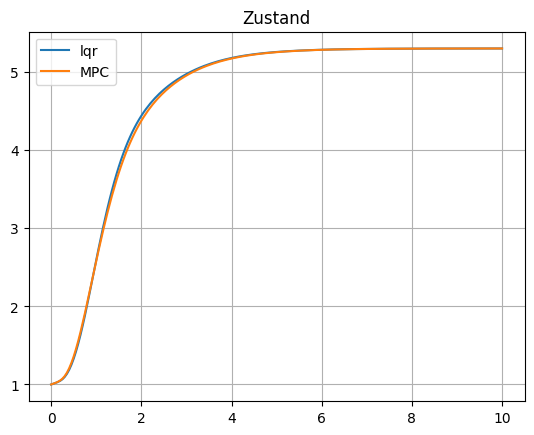

In [58]:
z =  0 # Zustand

plt.plot(thist,xhist2[z,:], label = 'lqr')
plt.plot(thist,xhist1[z,:], label = 'MPC')
plt.title('Zustand')
plt.legend()
print(xhist1[0,-1])
print(xhist1[1,-1])
print(xhist1[2,-1])
plt.grid()


[5.886 5.886]
[1.962 1.962]
4.905


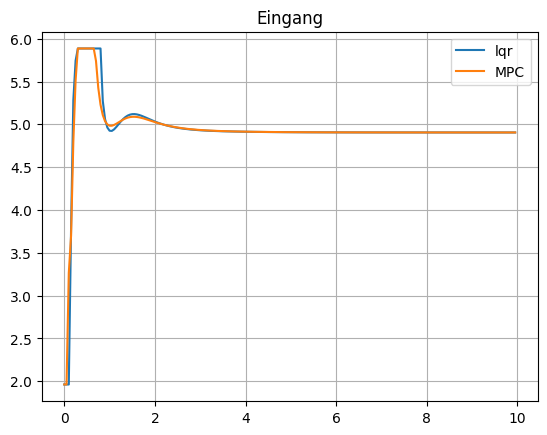

In [59]:
uz = 0

plt.plot(thist[:nsim-1],uhist2[uz,:nsim-1], label = 'lqr')
plt.plot(thist[:nsim-1],uhist1[uz,:nsim-1], label = 'MPC')
plt.title('Eingang')
plt.legend()
plt.grid()
print(umax)
print(umin)
print(u_hover)

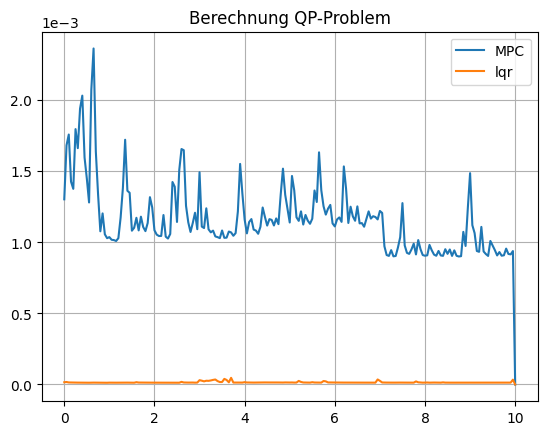

In [60]:
plt.plot(thist,time_qp1, label = 'MPC')
plt.plot(thist,time_qp2, label = 'lqr')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.title('Berechnung QP-Problem')
plt.legend()
plt.grid()